In [1]:
import torch
from models.networks import get_model
from torch import nn
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from data_utils.data_stats import *
import numpy as np
import matplotlib.pyplot as plt

/Users/charleslego/opt/anaconda3/envs/DL_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# These variables are needed to load the model

dataset = 'cifar10'                 
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model 
num_classes = CLASS_DICT[dataset]
data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [3]:
# Load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint='in21k_cifar10')

# Add a flattening layer to the model so it can take images as inputs
model = nn.Sequential(
    nn.Flatten(1, -1),model
)

Weights already downloaded
Load_state output <All keys matched successfully>


Create a random input

In [4]:
# Set seed values for PyTorch and NumPy for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)

#function that preprocesses the image to be as expected by the network
preprocess = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])

# creating an input
mean = 0.5
std = 0.5/3
input = mean + std*torch.randn((3,64,64)) # should be of size 3,64,64
input = preprocess(input)
input = input.to(device)
input.unsqueeze_(0) # create a mini-batch as expected by the model
input.requires_grad_()


tensor([[[[ 1.3345,  1.0380,  0.6423,  ...,  1.2790, -0.7642,  0.9680],
          [ 1.0095,  0.6124,  1.5309,  ...,  0.2641,  0.5204,  0.3123],
          [ 1.3374,  0.7173, -0.9340,  ..., -0.3401,  0.5098,  0.5136],
          ...,
          [-0.3436, -0.2910,  0.3565,  ..., -0.1482, -0.6084, -0.4196],
          [ 0.2423, -0.0513,  0.0595,  ..., -1.3183,  0.2253, -0.5123],
          [-1.0097,  0.0675, -0.4854,  ..., -0.0598,  0.6699,  0.0268]],

         [[-0.2826,  1.3410,  1.3301,  ...,  0.6847, -0.9614, -0.5097],
          [ 1.4980,  0.8039, -0.9041,  ...,  1.2101, -1.7217, -0.2225],
          [ 0.0040, -0.2272, -1.2804,  ...,  0.2173,  0.2467, -0.4278],
          ...,
          [ 0.2633,  0.5756, -0.1826,  ..., -0.2418,  0.1974,  0.1997],
          [ 0.5663, -0.1208,  0.1373,  ...,  0.0045, -1.5428,  1.6107],
          [-0.8333, -0.0619,  0.2730,  ...,  0.4433,  0.5481,  1.3437]],

         [[-0.3038,  0.8582,  0.9350,  ...,  0.9775,  0.8005,  0.1548],
          [-0.7287, -1.0424,  

Helper functions for visualization

In [5]:

# Function that takes an array an normalizes its content to be within the range 0-1
def norm_01(array):
    return(array-np.min(array))/(np.max(array)-np.min(array))

# Function that takes in an input batch (with only 1 element) and displays it as an image
def show_im(batch):
    img = batch.reshape(3,64,64).permute(1,2,0)
    img_np = img.detach().numpy()
    plt.imshow(norm_01(img_np))

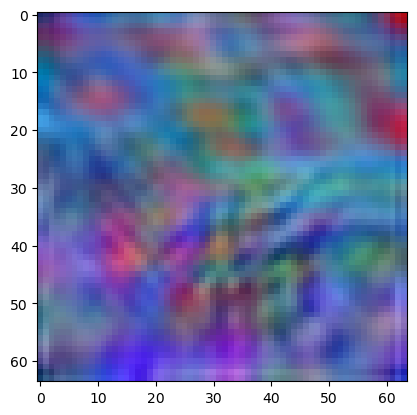

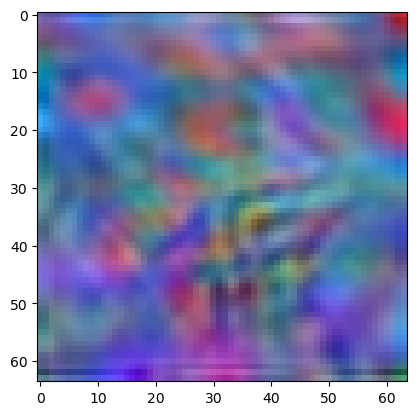

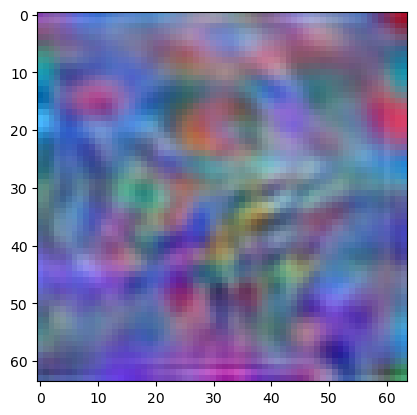

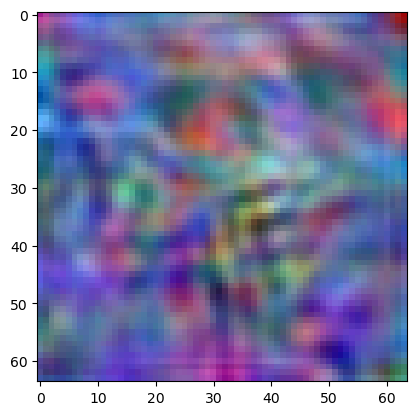

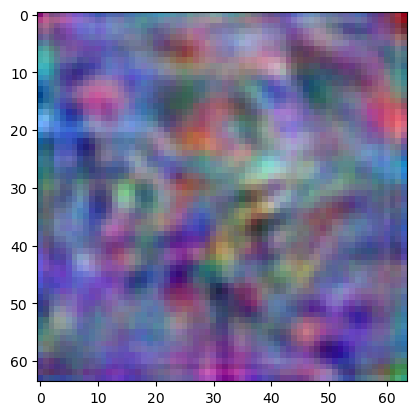

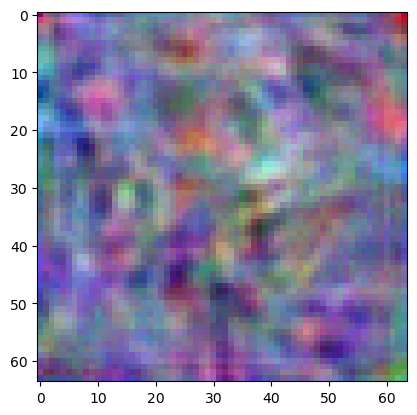

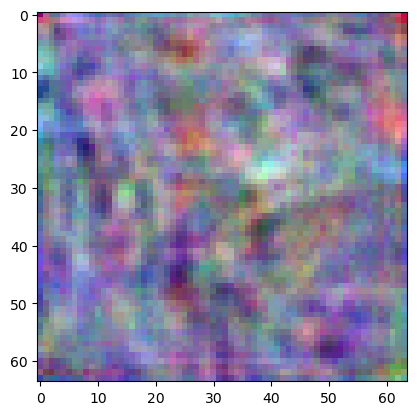

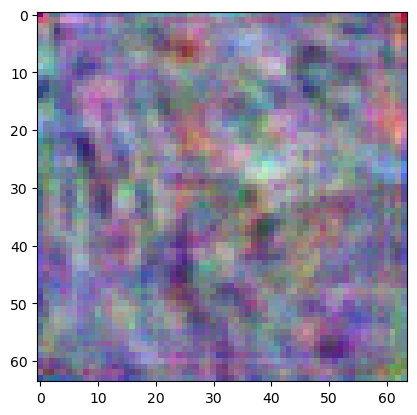

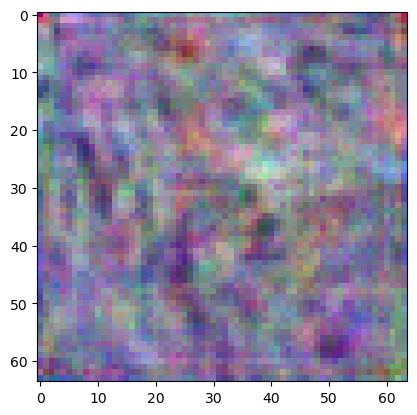

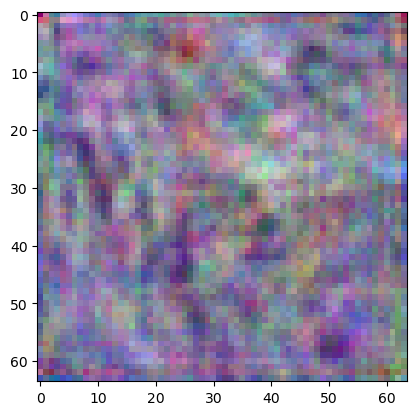

In [6]:
# Class I want to optimize
idx = 5 # 0: airplanes, 1: cars, 2: birds, 3: cats, 4: deer, 5: dogs, 6: frogs, 7: horses, 8: ships, 9: trucks

# Set hyper parameters
epochs = 1000
start_step_size = 0.01
end_step_size = 0.01
start_sig = 0.5 # Sigma of the gaussian kernel
end_sig = 0.1 

# These hyperparameters are not currently used
jitter = 0 
theta_decay = 0.01 

# Number of images you want to visualize
num_im_save = 10
checkpoints = []

# Gradient ascent loop
for epoch in range(epochs):
  
  model.zero_grad()
  if input.grad != None:
    input.grad.zero_()

  y_pred = model.forward(input)
  y_pred[0,idx].backward()
  g = input.grad

  ## Uncomment if you want to experiment with jitter
  # ox, oy = np.random.randint(-jitter, jitter+1, 2)
  with torch.no_grad():

    step_size = start_step_size + ((end_step_size - start_step_size) * epoch) / epochs
    input += step_size/np.abs(g).mean() * g

    ## apply jitter shift
    # input = input.roll( ox, -1) 
    # input = input.roll( oy, -2)

    ## Use weight decay
    # input = input.mul((1.0 - theta_decay)) 

    # Use Gaussian blurring
    sig = start_sig + ((end_sig - start_sig) * epoch) / epochs
    blurrer = transforms.GaussianBlur(kernel_size=5, sigma=sig)
    input = blurrer(input)    

  input.requires_grad_()

  if (epoch+1) % (epochs/num_im_save) == 0:
    checkpoints.append(input)
    show_im(input)
    plt.show()

